In [87]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

import warnings
warnings.simplefilter("ignore", UserWarning)


### Unfortunatley, YFinance does not provide the recommendations for all publicly traded companies.
### However, tech stocks and other large cap companies often work

In [88]:
#Change this variable to the ticker you are interested in analyzing (FAANG stocks work well and so do other large cap corps)
symbol = "NVDA"
ticker = yf.Ticker(symbol)

In [89]:
#Look at all reco types before we format them
df_base = ticker.recommendations.reset_index()
df = df_base.copy()
df['To Grade'].value_counts()

Buy                  119
Outperform            50
Hold                  31
Overweight            30
Neutral               25
Equal-Weight          17
Market Perform        12
Underperform           9
Underweight            8
Positive               6
Reduce                 4
Sector Weight          2
Sell                   2
Market Outperform      1
Equal-weight           1
Strong Buy             1
Perform                1
Negative               1
Sector Perform         1
Name: To Grade, dtype: int64

In [90]:
import datetime as dt
df['Date'] = df['Date'].dt.floor('D') # Remove seconds

In [91]:
df['To Grade'] = np.where((df['To Grade'].isin(['Outperform','Overweight','Positive','Market Outperform','Strong Buy'])),('Buy'),df['To Grade']) #Changing terms to Buy

In [92]:
df['To Grade'] = np.where((df['To Grade'].isin(['Neutral','Market Perform','Equal-Weight', 'Sector Perform','Perform','Equal-weight',
                                               'In-Line','Peer Perform','Sector Weight'])),
                                                'Hold',df['To Grade']) #Changing terms to Hold

In [93]:
df['To Grade'] = np.where((df['To Grade'].isin(['Underperform','Underweight','Reduce','Negative'])),
                                                'Sell',df['To Grade']) #Changing terms to Sell

In [94]:
df['To Grade'].value_counts()
#Check to make sure there aren't any significant reco types that we forgot to convert

Buy     207
Hold     90
Sell     24
Name: To Grade, dtype: int64

In [95]:
#Remove any values that are not buy/sell/hold
df = df.loc[(df['To Grade'] == 'Hold')|(df['To Grade']=='Buy')|(df['To Grade']=='Sell')].copy()

In [96]:
#Fix date formatting
df['Date'] = df['Date'].values.astype('<M8[M]')

In [97]:
prices = yf.download(symbol,interval = '1d', progress=False).reset_index()

### Create dfs for upcoming line/scatter plot

In [98]:
df_buy = df.loc[df['To Grade']=='Buy'].reset_index()
df_sell = df.loc[df['To Grade']=='Sell'].reset_index()

In [99]:
#Get bad dates for recos made on weekends that have no price
bad_dates_buy = df_buy.loc[df_buy.Date.isin(prices.Date)==False].Date.reset_index()
bad_dates_buy = bad_dates_buy.drop(columns = 'index')

bad_dates_sell = df_sell.loc[df_sell.Date.isin(prices.Date)==False].Date.reset_index()
bad_dates_sell = bad_dates_sell.drop(columns = 'index')

In [100]:
from datetime import datetime, timedelta
#Where there is a bad date, we move it back two days so it is no longer on a weekend and will be found in prices
df_buy.Date = np.where(df_buy.Date.isin(bad_dates_buy.Date), df_buy.Date - timedelta(days=2), df_buy.Date)
df_sell.Date = np.where(df_sell.Date.isin(bad_dates_sell.Date), df_sell.Date - timedelta(days=2), df_sell.Date)

In [116]:
#get buy and sell in prices df so we can scatter plot them on the price plot
plot_buy = prices.merge(df_buy,on='Date', how = 'left')
plot_sell = prices.merge(df_sell,on='Date', how = 'left')

In [117]:
plot_buy = plot_buy.loc[plot_buy['To Grade']=='Buy']
plot_sell = plot_sell.loc[plot_sell['To Grade']=='Sell']

In [118]:
prices = prices.reset_index()

In [119]:
df1 = prices.merge(df, on='Date',how='left')
df1.drop(columns = ['Open','High','Low','Close','Volume','From Grade'],inplace= True)

### Calculating percent return after different time periods

In [120]:
dt_adj = 261/365 #use to adjust our desired windows as US has 261 working days a year
time_periods = [30,60,180,360,360*2,360*3,360*5]

for period in time_periods:
    df1['{} day return'.format(period)] = df1.loc[:,'Adj Close'].pct_change(periods = int(dt_adj*period))


In [121]:
#Shifting the df columns back so that the future return is on the day the reco was made

for period in time_periods:
    df1['{} day return'.format(period)] = df1['{} day return'.format(period)].shift(-int(dt_adj*30))

df1.rename(columns = {'720 day return':'2 year return',\
                     '1080 day return':'3 year return',\
                     '1800 day return':'5 year return'}, inplace = True)

In [122]:
#Need to format df so that it can be used in a boxplot
return_gp = df1.groupby(['To Grade','Firm']).mean().reset_index()
return_gp.drop(columns = 'Adj Close',inplace=True)

return_melt = return_gp.melt(id_vars=['To Grade','Firm'])

return_melt_short = return_melt.loc[(return_melt['variable']=='30 day return')|
                                    (return_melt['variable']=='90 day return')|
                                    (return_melt['variable']=='180 day return')|
                                    (return_melt['variable']=='360 day return')]

return_melt_long = return_melt.loc[(return_melt['variable']=='2 year return')|
                                    (return_melt['variable']=='3 year return')|
                                   (return_melt['variable']=='5 year return')|
                                    (return_melt['variable']=='360 day return')]

In [123]:
def plot_prices(prices,plot_buy, plot_sell, ax= None):
    ax = ax or plt.gca()
    
    line_alpha = 0.6
    marker_alpha = 1
    line_color = 'b'
    buy_color = 'g'
    sell_color = 'r'
    marker_s = 70

    plt.plot(prices.Date, prices['Adj Close'], color =line_color, alpha=line_alpha)
    plt.scatter(x = plot_buy.Date, y = plot_buy['Adj Close'], color = buy_color, marker = '^', label = 'Buy Reco',s=marker_s, alpha = marker_alpha)
    plt.scatter(x = plot_sell.Date, y = plot_sell['Adj Close'], color = sell_color, marker = 'v', label = 'Sell Reco',s=marker_s, alpha=marker_alpha)
    plt.title('{} Buy and Sell Recommendations'.format(symbol))
    plt.xlabel('Year')
    plt.ylabel('Price')
    plt.legend(loc=2)
    
    datemin = plot_buy.Date.min() - timedelta(days=180)
    datemax = prices.Date.max() + timedelta(days=30)
    ax.set_xlim(datemin, datemax)
    return ax

In [132]:
def short_return_plot(return_melt_short, symbol, ax = None):
    ax = ax or plt.gca()

    sns.boxplot(x='variable',y = 'value', hue = 'To Grade',data = return_melt_short)
    plt.title('{} Short Run Percent Return After Reco'.format(symbol))
    plt.ylabel('Percent Return')
    plt.xlabel('Return Window')
    plt.legend(loc = 2)

    #Format y ticks to percentage
    y_vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.0f}%'.format(x * 100) for x in y_vals])

    return ax

In [133]:
def long_return_plot(return_melt_long, symbol, ax = None):
    ax = ax or plt.gca()
    
    sns.boxplot(x='variable',y = 'value', hue = 'To Grade',data = return_melt_long)
    plt.title('{} Long Run Percent Return After Reco'.format(symbol))
    plt.ylabel('Percent Return')
    plt.xlabel('Return Window')
    plt.legend(loc = 2)

    #Format y ticks to percentage
    y_vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.0f}%'.format(x * 100) for x in y_vals])

    return ax

In [134]:
def all_plots(prices, plot_buy, plot_sell, return_melt_short, return_melt_long, symbol):
    fig, ax = plt.subplots(3,1,figsize=(15,20))
    plt.subplots_adjust(hspace = 0.4)
    
    plt.subplot(3, 1, 1)
    plot_prices(prices, plot_buy, plot_sell)
    
    plt.subplot(3,1,2)
    short_return_plot(return_melt_short, symbol)
    
    plt.subplot(3,1,3)
    long_return_plot(return_melt_long, symbol)
    

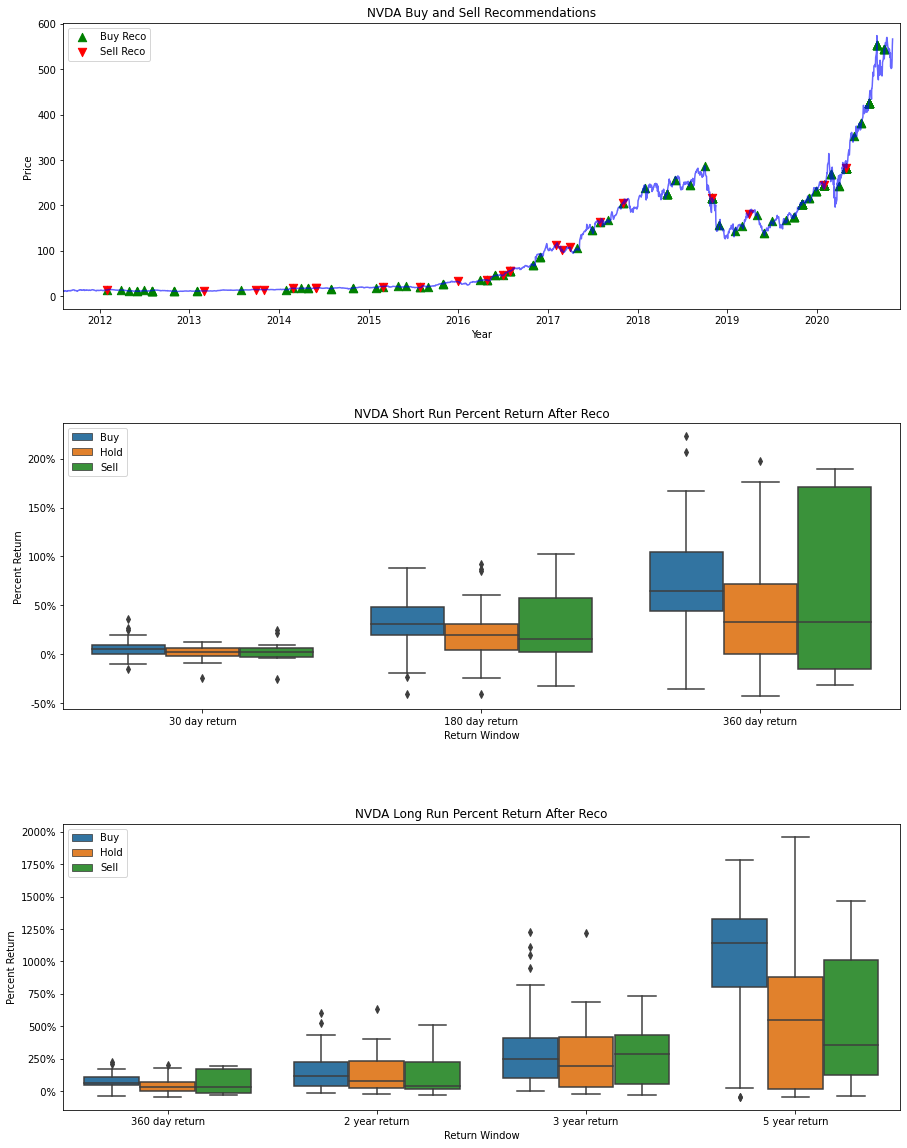

In [135]:
all_plots(prices,plot_buy, plot_sell, return_melt_short, return_melt_long, symbol)